In [2]:
import random
import copy


# defines generation, mutation, and recombination of chromosomes
# stores chromosomes as a set of alive cell coordinates
class Chromosome:
    def __init__(self, grid_size_limit):
        self.size_limit = grid_size_limit
        self.alive = set()

    # generates random start configuration
    def generate_random(self, min_size, max_size, min_coordinate, max_coordinate):
        size = random.randint(min_size, max_size)

        i = 0
        while i < size or len(self.alive) < min_size:
            i += 1
            x = random.randint(min_coordinate, max_coordinate)
            y = random.randint(min_coordinate, max_coordinate)
            self.add((x, y))


    # returns chromosome with one changed cell
    def mutate(self, min_size, max_size, min_coordinate, max_coordinate):
        if (len(self.alive) <= min_size):
            choice = 1 # add cell option
        elif (len(self.alive) >= max_size):
            choice = 0 # kill cell option
        else:
            choice = random.randint(0, 1)


        if (choice == 0): # kill option
            self.kill(random.choice(list(self.get_alive()))) #
        else:
            while True: # generating a random dead cell
                x = random.randint(min_coordinate, max_coordinate)
                y = random.randint(min_coordinate, max_coordinate)
                if (x, y) not in self.alive:
                    break
            self.add((x, y))

    # recombine this chromosome with another one generating 2 children
    # this is done by recombining the half the cells of both chromosomes
    # both cell sets are split into two halfs, this ensures that the amount of live cells in the children isn't too big or too small
    def recombine(self, other, min_size, max_size, min_coordinate, max_coordinate):
        child1 = Chromosome(self.get_size_limit())
        child2 = Chromosome(self.get_size_limit())

        cells = self.get_cell_list(min_coordinate, max_coordinate)

        cell_choices = random.choices(cells, k=int(len(cells) / 2))

        # creating child1
        for cell in cells:
            if cell in cell_choices and cell in self.get_alive(): # take cell from first parent
                child1.add(cell)
            elif cell not in cell_choices and cell in other.get_alive(): # take cell from second parent
                child1.add(cell)
        child1.adjust_size(min_size, max_size, min_coordinate, max_coordinate)
        
        # creating child2    
        for cell in cells:
            if cell not in cell_choices and cell in self.get_alive(): # take cell from first parent
                child2.add(cell)
            elif cell in cell_choices and cell in other.get_alive(): # take cell from second parent
                child2.add(cell)
        child2.adjust_size(min_size, max_size, min_coordinate, max_coordinate)

        return [child1, child2]
    
    # adding or decreasing the number of alive cells in a chromosome to be in a certain range
    # using the mutate() function
    def adjust_size(self, min_size, max_size, min_coordinate, max_coordinate):
        while len(self.alive) < min_size or len(self.alive) > max_size:
            self.mutate(min_size, max_size, min_coordinate, max_coordinate)

    # creates the list of possible cells for the chromosome
    def get_cell_list(self, min_coordinate, max_coordinate):
        size = max_coordinate - min_coordinate

        cell = []

        for x in range(min_coordinate, min_coordinate + size):
            for y in range(min_coordinate, min_coordinate + size):
                cell.append((x, y))

        return cell


    # returns set of alive cell coordinates
    def get_alive(self):
        return self.alive
    
    
    def get_size_limit(self):
        return self.size_limit
    
    def add(self, cell):
        self.alive.add(cell)
        
    def kill(self, cell):
        self.alive.remove(cell)


In [3]:
import copy

# stores the rules of the game of life and an initial state
# can simulate running the game to see if the initial state is a methuselah
class Life:
    def __init__(self, chromosome):
        self.state = copy.deepcopy(chromosome.get_alive())
        self.grid_size = chromosome.get_size_limit()
        self.generation = 0
        self.history = []  # array of past generations
        self.lifespan = 0
        self.cycle_length = 0
        self.max_size = 0

    # returns 1 if the cell is alive in the next generation, 0 if dead
    def get_new_cell_state(self, row, col):

        # counting number of neigbours
        neighbours = 0
        for x in range(row - 1, row + 2):
            for y in range(col - 1, col + 2):
                if x == row and y == col: # skip cell itself
                    continue
                
                if (x, y) in self.state:
                    neighbours += 1

        if (row, col) in self.state:
            if neighbours == 2 or neighbours == 3:
                return 1
            else:
                return 0
        else:  # if dead
            if neighbours == 3:
                return 1
            else:
                return 0

    # moving to the next generation, and updating the alive sets accordinly
    def next_generation(self):
        new = set()
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                if self.get_new_cell_state(x, y) == 1:
                    new.add((x, y))

        self.history.append(copy.deepcopy(self.state))
        self.state = new
        self.generation += 1

    # simulate game of life on the chromosome, returns true if it is a methuselah
    def simulate_methuselah(self, max_generation, min_lifespan, max_cycle_size):
        self.max_size = 0

        while self.generation < max_generation and not self.stabilized():
            self.max_size = max(self.max_size, len(self.state))
            self.next_generation()

            if (len(self.history) > max_cycle_size + 1):
                self.history = self.history[1:]
        
        if self.generation > min_lifespan and self.stabilized():
            self.cycle_length = len(self.history) - self.history.index(self.state)
            return True
        else:
            return False

    # returns if the simulation has reached a state it has already been at
    def stabilized(self):
        return self.state in self.history

    def get_state(self):
        return self.state
    
    def get_max_size(self):
        return self.max_size

    def get_lifespan(self):
        return self.generation - self.cycle_length

    def get_grid_size(self):
        return self.grid_size

In [4]:
# genetic algorithm is a class which finds the best methuselah it can in the game of life
# it treats an initial state of the game of life as a chromosome
# it stores the 'configurations' for the game of life which all have default values but can be changed
class GeneticAlgorithm:
    def __init__(self, grid_size = 50, chromosome_min_size = 4, chromosome_max_size = 12,
                 population_size = 6, chromosome_max_grid_size = 6,
                 generation_limit = 500, min_lifespan = 50, max_cycle_size = 50,
                 mutation_chance = 0.3):
        self.grid_size = grid_size

        self.chromosome_min_size = chromosome_min_size
        self.chromosome_max_size = chromosome_max_size
        self.chromosome_max_grid_size = chromosome_max_grid_size
        
        # boundaries of the initial chromosome state cell
        self.min_coordinate = int(grid_size / 2) - int(chromosome_max_grid_size / 2)
        self.max_coordinate = int(grid_size / 2) + int(chromosome_max_grid_size / 2)

        self.population_size = population_size
        self.generation_limit = generation_limit
        self.min_lifespan = min_lifespan
        self.max_cycle_size = max_cycle_size

        self.mutation_chance = mutation_chance
        self.population = []

        self.fittest = None
        self.max_fitness = 0
        self.fitness_data = []
        
        self.interm_solutions = []

    # runs the genetic algorithm for a specified number of generation
    # returns the fittest chromosome found
    def run(self, generations):
        self.create_population()
        # so that run can be called multiple times.
        self.fittest = None
        self.max_fitness = 0
        self.fitness_data = []
        self.fitness_data.append(max(self.fitness)) # collecting fitness data
        
        for i in range(1, generations):
            print(i)
            self.generate_next_population()
            
            self.fitness_data.append(max(self.fitness)) # collecting fitness data
            if self.fitness_data[i] > self.fitness_data[i-1] and self.fitness_data[i] >= 1: 
                self.interm_solutions.append((self.fittest, i)) # storing interm solutions
        
        print("max fitness")
        print(self.max_fitness)

    # generates a new random population using the class parameters
    def create_population(self):
        self.population = []
        for i in range(self.population_size):
            chromosome = Chromosome(self.grid_size)
            chromosome.generate_random(self.chromosome_min_size, self.chromosome_max_size,
                                       self.min_coordinate, self.max_coordinate)
            self.population.append(chromosome)

        self.evaluate_population()

    # inner function that evaluates the fitness and probability for offspring of each chromosome
    def evaluate_population(self):
        self.fitness = []
        fitness_sum = 0

        for i in range(self.population_size):
            self.fitness.append(self.get_fitness(self.population[i]))

            if self.fitness[i] > self.max_fitness:
                self.max_fitness = self.fitness[i]
                self.fittest = self.population[i]
                
            


    # getting the fitness of the chromosome
    # the fitness is the ratio of the initial size and the max size which is at most 1
    # if the chromosome is not found to be a methuselah the fitness is 0.5
    def get_fitness(self, chromosome):
        game = Life(chromosome)

        if (game.simulate_methuselah(self.generation_limit, self.min_lifespan, self.max_cycle_size)):
            return game.get_max_size() / len(chromosome.get_alive()) # ratio of sizes if chromosome is methuselah
        else: # not a methuselah
            return 1 - 0.5 * len(chromosome.get_alive()) / game.get_max_size() # between 0.5 and 1
            

    # creating the next generation of population
    # by creating offspring from the last generation until we have a population of the same size
    # and then mutating some
    def generate_next_population(self):
        next = []

        while len(next) < self.population_size:
            next += self.create_offspring()
        

        if len(next) > self.population_size:
            next = next[:-1]

        self.population = next
        self.mutate_population()
        self.evaluate_population()

    # each chromosome in the population mutates with a predetermined probability
    def mutate_population(self):
        options = [0, 1]
        weights = [1 - self.mutation_chance, self.mutation_chance]

        for chromosome in self.population:
            choice = random.choices(options, weights=weights, k=1)[0]
            if choice == 1:
                chromosome.mutate(self.chromosome_min_size, self.chromosome_max_size,
                                  self.min_coordinate, self.max_coordinate)

    # creates two offspring by recombination
    # uses roulette whell selection to choose the parents
    # implemented with the choices function
    def create_offspring(self):
        parents = random.choices(self.population, weights=self.fitness, k=2)
        return parents[0].recombine(parents[1], self.chromosome_min_size, self.chromosome_max_size, self.min_coordinate, self.max_coordinate)

    # returning the graph of fitness
    def get_fitness_data(self):
        return self.fitness_data

    def get_fittest(self):
        return self.fittest

    def get_interm_solutions(self):
        return self.interm_solutions
    
    def get_generation_limit(self):
        return self.generation_limit
    
    def get_min_lifespan(self):
        return self.min_lifespan
    
    def get_max_cycle_size(self):
        return self.max_cycle_size


In [5]:

import tkinter as tk

class GUI:
    # initializing parameters of the game and creating graphics
    def __init__(self, chromosome, info, cell_size=10, speed=1, generation_limit = 500, min_lifespan = 50, max_cycle_size = 50):
        self.cell_size = cell_size
        self.speed = speed
        self.grid = Life(chromosome)
        self.methuselah = Life(chromosome)
        self.methuselah.simulate_methuselah(generation_limit, min_lifespan, max_cycle_size)
        self.info = info
        
        self.window = tk.Tk()
        self.canvas = tk.Canvas(self.window, width=self.grid.get_grid_size() * self.cell_size,
                                height=self.grid.get_grid_size() * self.cell_size, bg='white')
        self.canvas.pack()
        self.window.resizable(False, False)
        self.window.title('Game of Life')

        self.draw_grid()
        self.create_label()
        self.create_buttons()
        self.window.mainloop()

    # creating buttons
    def create_buttons(self):
        # Create a start button
        self.start_button = tk.Button(
            self.window, text='Start', command=self.run)
        # Create a stop button
        self.stop_button = tk.Button(
            self.window, text='Next', command=self.window.destroy)
        # Create a reset button
        self.reset_button = tk.Button(
            self.window, text='Reset', command=self.reset)
        # Create a speed slider
        self.speed_slider = tk.Scale(self.window, from_=1, to=100, orient=tk.HORIZONTAL,
                                     label='Speed', command=self.change_speed)
        self.speed_slider.set(self.speed)

        self.start_button.pack()
        self.reset_button.pack()
        self.stop_button.pack()
        self.speed_slider.pack()

    # adds generation label to grid
    def create_label(self):
        self.generation = 0
        self.label = tk.Label(
        self.window, text=self.get_label_text())
        self.label.pack()
        
        self.info = tk.Label(self.window, text=self.info)
        self.info.pack()
        
    def get_label_text(self):
        return f'Generation: {self.generation}, LifeSpan: {self.methuselah.get_lifespan()}'
    
    # drawing the cells of the grid
    def draw_grid(self):
        for row in range(self.grid.get_grid_size()):  # Loop through the rows
            for col in range(self.grid.get_grid_size()):  # Loop through the columns
                x1 = col * self.cell_size
                y1 = row * self.cell_size
                x2 = x1 + self.cell_size
                y2 = y1 + self.cell_size
                # If the cell is alive
                if (row, col) in self.grid.get_state():
                    self.canvas.create_rectangle(
                        x1, y1, x2, y2, fill='green', outline='black')
                # If the cell is dead
                else:
                    self.canvas.create_rectangle(
                        x1, y1, x2, y2, fill='white', outline='black')
    
    # start button function
    def run(self):
        self.update()
    
    
    # continiously updates the window
    def update(self):
        self.grid.next_generation()
        self.canvas.delete('all')
        
        self.draw_grid()
        self.window.after(500//self.speed, self.update)
        
        self.generation += 1
        self.label.config(text=self.get_label_text())
        
    
    # resets window
    def reset(self):
        self.grid = Life(chromosome)
        self.canvas.delete('all')
        self.draw_grid()
        # Reset the generation
        self.generation = 0
        
    def change_speed(self, speed):
        self.speed = int(speed)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
max fitness
13.6


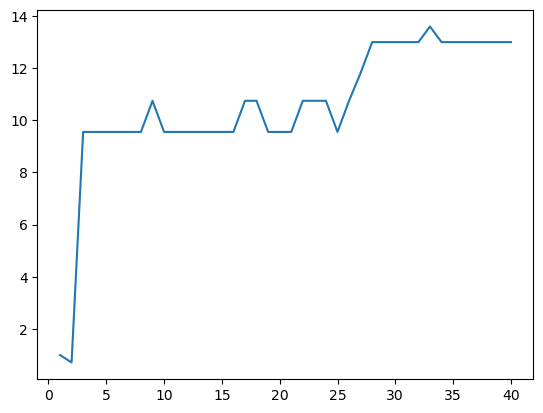

In [6]:
import matplotlib.pyplot as plt
import numpy as np

algo = GeneticAlgorithm(grid_size=30, generation_limit=500, population_size=8)
generations = 40
algo.run(generations)



fig = plt.plot(np.arange(1, generations + 1), algo.get_fitness_data())




In [7]:
interms = algo.get_interm_solutions()
info = []
chromosomes = []

for interm in interms:
    chromosomes.append(interm[0])
    fitness = algo.get_fitness(interm[0])
        
    text = "solution gen {}, fitness of {}".format(interm[1], fitness)
    info.append(text)
    
print(f'{len(interms)} interm solutions')
for i in range(len(info)) :
    GUI(chromosomes[i], info[i])

8 interm solutions
